In [1]:
# importing necessary libraries
import csv
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.optimize import curve_fit

In [2]:
# reading the dataset

i = 0
data_list = []
with open('API_19_DS2_en_csv_v2_4028487.csv', 'r') as file:
    reader = csv.reader(file, delimiter = ',')
    for row in reader:
        if i >= 4:
            data_list.append(row)
        i += 1
        
        
data_array = np.array(data_list)
df = pd.DataFrame(data_array[1:, :], columns = data_array[0])

In [3]:
# data cleaning (replacing empty string by NaN value to be interpreted as float)
df[df == ''] = np.nan
df.iloc[:, 4:] = df.iloc[:, 4:].astype('float')

In [4]:
# selecting the following features:

## 1. CO2 emissions (kg per 2017 PPP $ of GDP)
## 2. CO2 emissions (kg per PPP $ of GDP)
## 3. CO2 emissions (kg per 2015 US$ of GDP)

data = df.loc[df['Indicator Name'].isin([
#                                         'Agriculture, forestry, and fishing, value added (% of GDP)', 
                                         'CO2 emissions (kg per 2017 PPP $ of GDP)',
                                         'CO2 emissions (kg per PPP $ of GDP)',
                                         'CO2 emissions (kg per 2015 US$ of GDP)',
#                                         'Energy use (kg of oil equivalent) per $1,000 GDP (constant 2017 PPP)', 
#                                         'Foreign direct investment, net inflows (% of GDP)']
                                        ]), :]

In [5]:
# selecting the last 21 years (2000-2021)
years = [str(year) for year in range(2000, 2022)]

# analyzing the data by taking the indicators as features per country for the years 2000-2021
data_per_country = pd.pivot_table(data = data,
                                  index = 'Country Name',
                                  columns = 'Indicator Name',
                                  values = years)

In [6]:
# selecting the data for the year 2018
data_for_clustering = data_per_country['2018'].copy()
data_for_clustering.dropna(inplace = True)

In [7]:
# user-function for data normalization
def normalize(series):
    minmaxscaler = MinMaxScaler().fit(series)
    return minmaxscaler

In [8]:
# data normalization for clustering
minmaxscaler = normalize(data_for_clustering)
normalized_data_clustering = minmaxscaler.transform(data_for_clustering)
normalized_data_clustering = pd.DataFrame(normalized_data_clustering, 
                                          index = list(data_for_clustering.index),
                                          columns = list(data_for_clustering.columns))

In [9]:
normalized_data_clustering

CO2 emissions (kg per 2015 US$ of GDP)  \
Afghanistan                                                0.164950   
Africa Eastern and Southern                                0.311002   
Africa Western and Central                                 0.126248   
Albania                                                    0.211745   
Algeria                                                    0.444681   
...                                                             ...   
Vanuatu                                                    0.090175   
Vietnam                                                    0.572988   
World                                                      0.198622   
Zambia                                                     0.150776   
Zimbabwe                                                   0.280310   

                             CO2 emissions (kg per 2017 PPP $ of GDP)  \
Afghanistan                                                  0.083196   
Africa Eastern and Southern                                  0.253428   
Africa Western and Central                                   0.112683   
Albania                                                      0.136089   
Algeria                                                      0.318743   
...                                                               ...   
Vanuatu                                                      0.195597   
Vietnam                                                      0.371311   
World                                                        0.274861   
Zambia                                                       0.114829   
Zimbabwe                                                     0.215530   

                             CO2 emissions (kg per PPP $ of GDP)  
Afghanistan                                             0.083196  
Africa Eastern and Southern                             0.255262  
Africa Western and Central                              0.112683  
Albania                                                 0.137765  
Algeria                                                 0.318743  
...                                                          ...  
Vanuatu                                                 0.195597  
Vietnam                                                 0.371311  
World                                                   0.274798  
Zambia                                                  0.114829  
Zimbabwe                                                0.215530  

[230 rows x 3 columns]

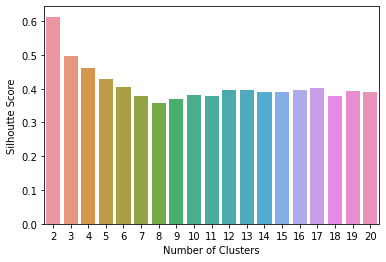

In [10]:
# silhouette scoring method for selecting best k in k-Means Clustering
silhouette_scorelist = []
for num_clusters in list(range(2,21)):
    model_clus = KMeans(n_clusters = num_clusters, max_iter=50, random_state = 1234)
    model_clus.fit(normalized_data_clustering)
    silhouette_scorelist.append([num_clusters, silhouette_score(normalized_data_clustering, model_clus.labels_)])

silhouette_scorelistdf = pd.DataFrame(silhouette_scorelist, columns = ['n_clusters', 'silhoutte_score'])
sns.barplot(x = 'n_clusters', y = 'silhoutte_score', data = silhouette_scorelistdf)
plt.xlabel('Number of Clusters')
plt.ylabel('Silhoutte Score')
plt.show()

In [11]:
# applying k-Means Clustering on the normalized data 
kmeans = KMeans(n_clusters = 2, max_iter=50, random_state = 1234).fit(normalized_data_clustering)
clustering_labels = kmeans.labels_
data_for_clustering['cluster'] = clustering_labels

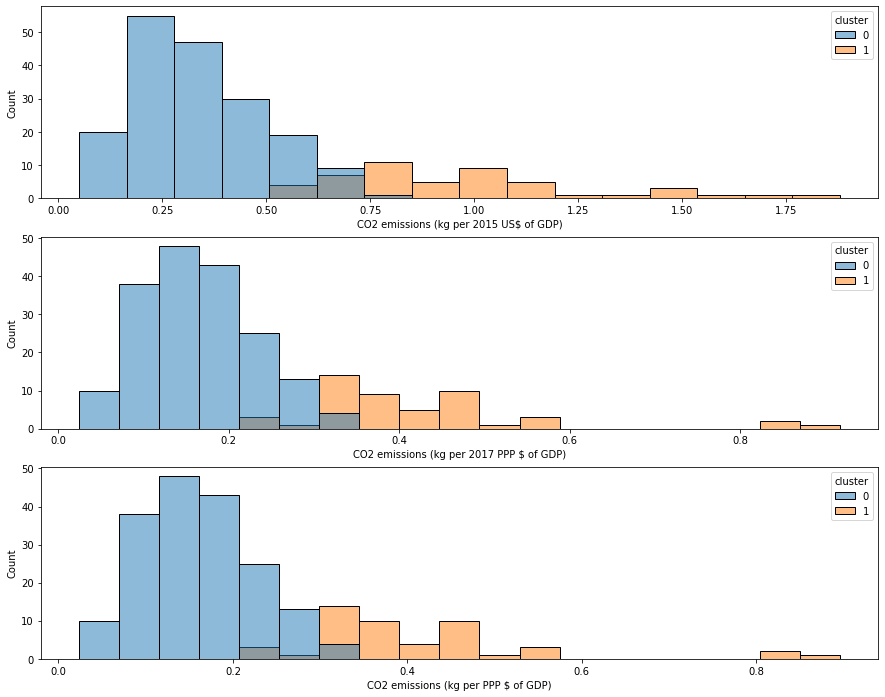

In [12]:
# Histogram Visualization of the CO2 Emission Features for the 2 Clusters
plt.figure(figsize = (15, 12))

plt.subplot(3, 1, 1)
sns.histplot(x = 'CO2 emissions (kg per 2015 US$ of GDP)',
             data = data_for_clustering,
             hue = 'cluster')
plt.subplot(3, 1, 2)
sns.histplot(x = 'CO2 emissions (kg per 2017 PPP $ of GDP)',
             data = data_for_clustering,
             hue = 'cluster')
plt.subplot(3, 1, 3)
sns.histplot(x = 'CO2 emissions (kg per PPP $ of GDP)',
             data = data_for_clustering,
             hue = 'cluster')
plt.show()

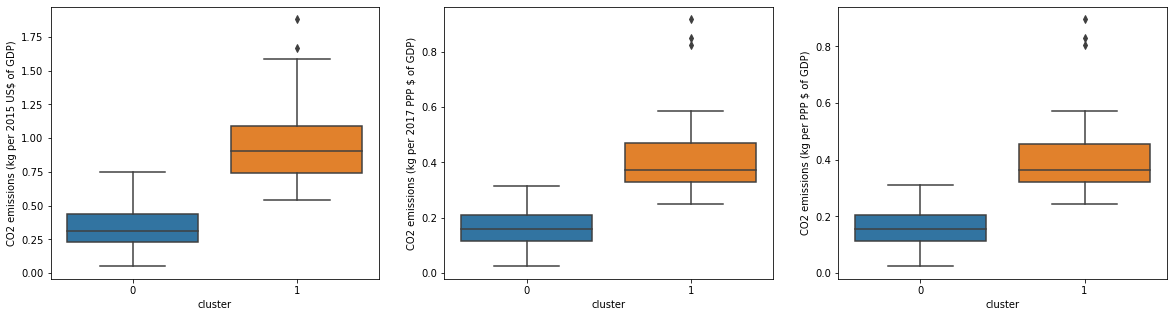

In [13]:
# Boxplot Visualization of the CO2 Emission Features for the 2 Clusters
plt.figure(figsize = (20, 5))

plt.subplot(1, 3, 1)
sns.boxplot(x = 'cluster',
            y = 'CO2 emissions (kg per 2015 US$ of GDP)',
            data = data_for_clustering)
plt.subplot(1, 3, 2)
sns.boxplot(x = 'cluster',
            y = 'CO2 emissions (kg per 2017 PPP $ of GDP)',
            data = data_for_clustering)
plt.subplot(1, 3, 3)
sns.boxplot(x = 'cluster',
            y = 'CO2 emissions (kg per PPP $ of GDP)',
            data = data_for_clustering)
plt.show()

In [14]:
# data for curve-fitting (predicting Foreign Direct Investment from Energy Usage)
## 1. Energy use (kg of oil equivalent) per $1,000 GDP (constant 2017 PPP)
## 2. Foreign direct investment, net inflows (% of GDP)

fit_data = df.loc[df['Indicator Name'].isin(['Energy use (kg of oil equivalent) per $1,000 GDP (constant 2017 PPP)', 
                                             'Foreign direct investment, net inflows (% of GDP)']
                                            ), :]

# selecting the last 21 years (2000-2021)
years = [str(year) for year in range(2000, 2022)]

# analyzing the data by taking the indicators as features per country for the years 2000-2021
fit_data_per_country = pd.pivot_table(data = fit_data,
                                      index = 'Country Name',
                                      columns = 'Indicator Name',
                                      values = years)

In [15]:
# selecting the data for the year 2015
fit_data_energy_fdi = fit_data_per_country.loc[:, '2015'].dropna()
x_train_data = fit_data_energy_fdi['Energy use (kg of oil equivalent) per $1,000 GDP (constant 2017 PPP)']
y_train_data = fit_data_energy_fdi['Foreign direct investment, net inflows (% of GDP)']

In [16]:
# defining the model function
def func_model(x, a, b, c):
    return a*(x**-2) + (b/x) + c

# executing the curve fit
popt, pcov = curve_fit(func_model, x_train_data, y_train_data)

In [17]:
# using the err_ranges function to estimate lower and upper ranges of the confidence range
def err_ranges(x, func, param, sigma):
    """
    Calculates the upper and lower limits for the function, parameters and
    sigmas for single value or array x. Functions values are calculated for 
    all combinations of +/- sigma and the minimum and maximum is determined.
    Can be used for all number of parameters and sigmas >=1.
    
    This routine can be used in assignment programs.
    """

    import itertools as iter
    
    # initiate arrays for lower and upper limits
    lower = func(x, *param)
    upper = lower
    
    uplow = []   # list to hold upper and lower limits for parameters
    for p,s in zip(param, sigma):
        pmin = p - s
        pmax = p + s
        uplow.append((pmin, pmax))
        
    pmix = list(iter.product(*uplow))
    
    for p in pmix:
        y = func(x, *p)
        lower = np.minimum(lower, y)
        upper = np.maximum(upper, y)
        
    return lower, upper

sigma = y_train_data - func_model(x_train_data, *popt)
l, u = err_ranges(x_train_data.sort_values(), func_model, popt, sigma)
plt.figure(figsize = (10, 5))
plt.plot(x_train_data.sort_values(), l, 'r--', label = 'Upper Confidence Level')
plt.scatter(x_train_data, y_train_data, label = 'original')
plt.plot(x_train_data.sort_values(), func_model(x_train_data.sort_values(), *popt), color = 'red', 
         label = 'fit: a=%5.1f, b=%5.1f, c=%5.1f' % tuple(popt))
plt.plot(x_train_data.sort_values(), u, 'r--', label = 'Lower Confidence Level')

plt.xlabel('Energy use (kg of oil equivalent) per $1,000 GDP (constant 2017 PPP)')
plt.ylabel('Foreign direct investment, net inflows (% of GDP)')
plt.legend()
plt.title('2015')
plt.show()

In [18]:
# selecting a country from each cluster and finding the Foreign Direct Investment from Energy Usage
cluster_countries = pd.merge(fit_data_energy_fdi.reset_index(), data_for_clustering.reset_index(), how = 'inner', 
                             on = 'Country Name')

country_cluster0 = cluster_countries.loc[cluster_countries.cluster == 0, 'Country Name']
print(country_cluster0.head(1))
print()
print('Foreign direct investment, net inflows (% of GDP):', func_model(x_train_data, *popt)[list(country_cluster0.index)[0]])
print()
print()
country_cluster1 = cluster_countries.loc[cluster_countries.cluster == 1, 'Country Name']
print(country_cluster1.head(1))
print()
print('Foreign direct investment, net inflows (% of GDP):', func_model(x_train_data, *popt)[list(country_cluster1.index)[0]])

0    Australia
Name: Country Name, dtype: object

Foreign direct investment, net inflows (% of GDP): 1.729087701280239


7    Estonia
Name: Country Name, dtype: object

Foreign direct investment, net inflows (% of GDP): 3.1580088557011585
